# Sparkify Capstone Project - Udacity Data Science Nanodegree

Sparkify is a streaming service that offers music, similarly to other currently known services such as Spotify. As a user, you can interact with the service and choose your favourite artists, songs, create playlists or add friends. Any time you like, you can give a thumbs up or down. You may decide whether you are happy with the free subscription (and bear the reappearing advertisements) or you are ready to pay for it. You can change your subscription plan any time you want, upgrading or downgrading multiple times. Finally, you can decide to completely quit the app.  But what makes you want to do it?

This is the question I want to focus on in this article. I want to bring closer to you my approach to and results of a project where I aim at predicting if and why any user would be likely to churn and quit the service provided by Sparkify. 
Sparkify is a company just like any other, just it is fictitious. Consequently, the dataset consists of simulated logs of user interaction with the service within an observation period. The project itself is a part of the Data Science Nanodegree, organized by Udacity, who provided the dataset.


## Problem Statement

As stated, the goal is to be able to predict whether a user is about to churn the service and possibly have a deeper insight on what it depends on. Successful prediction would be the first step to keep the customer, as it would prompt an action in form of sending some incentives, analysing discouraging factors, sending personal recommendations and similar. 
It is advantageous to have customers with paid subscription, however the real problem is to have a customer quit (and not being able to address her/him as a customer anymore), so churning is defined here as quitting the service all together.

The entire development process (data exploration, feature engineering, model selection) is conducted on a subset (1/100) of the full dataset. Model selected after this process can be further trained and tested on the full dataset. Because of its size it cannot be processed locally and has to be processed in the cloud, for example on the EMR cluster (Elastic MapReduce). That is out of scope of this development notebook, yet the logic stays the same.

Because of that, the project is realised utilizing advantages of Apache Spark distributed computing framework. In particular, its python API, PySpark and SparkML are used during the development process.

To this end, I divide the strategy for solving the problem into the following steps that I comment on in the next sections:	 	

* Data exploration:
    * load the data
    * deal with incomplete data, identify outliers 
    * visualize and understand correlations
* Feature engineering:
    * transform the data into a dataset of one sample record per user, aggregating features and performing statistics on them
    * decide what features to take or what potential new features to engineer
    * define the target response variable for training
* Modeling and evaluation: 
     * define objective in mathematical terms
     * create proper metric to track performance
     * come up with suitable models and train them
     * evaluate various models according to the chosen metrics and decide for the most promising one
     * refine the model


In [5]:
# import libraries

from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DateType, TimestampType
from pyspark.sql.functions import first, col, last, when, lag, count 
from pyspark.sql.functions import sum as spark_sum

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Analysis") \
    .getOrCreate()

In [7]:
# Check the current configuration
spark.sparkContext.getConf().getAll()

[('spark.app.name', 'Sparkify Analysis'),
 ('spark.driver.port', '42085'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.id', 'local-1588778429078'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.host', 'ff1ac259f73b'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

# I Data Exploration

Columns and their meaning:
The columns can be grouped into a few categories of features:

**User-related features:**

Static, not changing for the same user:
* **userId (string)**       - identifier of the user
* **firstName (string)**    - first name of the user
* **gender (string)**       - gender of the user (M, F)
* **lastName (string)**     - last name of the user
* **location (string)**     - location of the user while using the app
* **userAgent (string)**    - agent/browser used by the user to stream
* **registration (bigint)** - timestamp for the registration of the user

Dynamic, changing for the same user in various logs:
* **level (string)** - type of subscription (paid, free)


**Log-related features:** describing user-service interaction
* **sessionId (bigint)**     - identifier of the session
* **ts (bigint)**            - timestamp of the given log
* **page (string)**          - user-service interaction type, 22 categories
* **auth (string)**          - level of the authentication (logged out, cancelled, guest, logged in)
* **itemInSession (bigint)** - count of the logs in the given session
* **method (string)**        - http request method (GET, PUT)
* **status (bigint)**        - http status code (200, 307, 404)

**Song-related features:**
* **artist (string)** - artist of the song
* **song (string)**   - title of the song
* **length (double)** - song's length in sec

## Load the dataset

In [8]:
df = spark.read.json("mini_sparkify_event_data.json")
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



## Get the overview of the dataframe

Since pandas presents the dataframe in a more conscise and clear manner than spark:

In [9]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
artist,Martha Tilston,Five Iron Frenzy,Adam Lambert,Enigma,Daft Punk
auth,Logged In,Logged In,Logged In,Logged In,Logged In
firstName,Colin,Micah,Colin,Micah,Colin
gender,M,M,M,M,M
itemInSession,50,79,51,80,52
lastName,Freeman,Long,Freeman,Long,Freeman
length,277.89,236.094,282.827,262.713,223.608
level,paid,free,paid,free,paid
location,"Bakersfield, CA","Boston-Cambridge-Newton, MA-NH","Bakersfield, CA","Boston-Cambridge-Newton, MA-NH","Bakersfield, CA"
method,PUT,PUT,PUT,PUT,PUT


In [10]:
print(f"The small datasample has {df.count()} rows and {len(df.columns)} columns.")

The small datasample has 286500 rows and 18 columns.


In [11]:
# how many duplicates can be dropped
print(f"Dataframe has {df.count() - df.dropDuplicates().count()} duplicates.")

Dataframe has 0 duplicates.


## Explore on chosen columns

In [12]:
# itemInSession, length, method, registration, status, 
drop_columns = ['artist', 'firstName', 'lastName', 'location', 'song', 'userAgent', 'length']
keep_columns = ['auth', 'gender', 'level', 'page', 'ts', 'userId', 'registration', 'sessionId']

show_columns = ['auth', 'gender', 'level', 'page']
def get_possible_values_columns(columns):
    for column in columns:
        df.select(column).distinct().show(50)
get_possible_values_columns(show_columns)

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+

+------+
|gender|
+------+
|     F|
|  null|
|     M|
+------+

+-----+
|level|
+-----+
| free|
| paid|
+-----+

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [13]:
df = df.select(*keep_columns) 

### Explore features: ts, registration

Create new columns with timestamp and registration time, formatted in a more readible way

In [14]:
df = df.withColumn('registration_date', (df['registration'] / 1000).cast(TimestampType()))
df = df.withColumn('ts_date', (df['ts'] / 1000).cast(TimestampType()))

In [15]:
df.show(5)

+---------+------+-----+--------+-------------+------+-------------+---------+-------------------+-------------------+
|     auth|gender|level|    page|           ts|userId| registration|sessionId|  registration_date|            ts_date|
+---------+------+-----+--------+-------------+------+-------------+---------+-------------------+-------------------+
|Logged In|     M| paid|NextSong|1538352117000|    30|1538173362000|       29|2018-09-28 22:22:42|2018-10-01 00:01:57|
|Logged In|     M| free|NextSong|1538352180000|     9|1538331630000|        8|2018-09-30 18:20:30|2018-10-01 00:03:00|
|Logged In|     M| paid|NextSong|1538352394000|    30|1538173362000|       29|2018-09-28 22:22:42|2018-10-01 00:06:34|
|Logged In|     M| free|NextSong|1538352416000|     9|1538331630000|        8|2018-09-30 18:20:30|2018-10-01 00:06:56|
|Logged In|     M| paid|NextSong|1538352676000|    30|1538173362000|       29|2018-09-28 22:22:42|2018-10-01 00:11:16|
+---------+------+-----+--------+-------------+-

Find the observation window in time

In [16]:
print(f"Beginning of the observation period: {'2018-10-01 00:01:57'}")
df.select('userId', 'page', 'ts', 'ts_date').sort('ts').show(10)

Beginning of the observation period: 2018-10-01 00:01:57
+------+---------------+-------------+-------------------+
|userId|           page|           ts|            ts_date|
+------+---------------+-------------+-------------------+
|    30|       NextSong|1538352117000|2018-10-01 00:01:57|
|     9|       NextSong|1538352180000|2018-10-01 00:03:00|
|    30|       NextSong|1538352394000|2018-10-01 00:06:34|
|     9|       NextSong|1538352416000|2018-10-01 00:06:56|
|    30|       NextSong|1538352676000|2018-10-01 00:11:16|
|     9|       NextSong|1538352678000|2018-10-01 00:11:18|
|     9|       NextSong|1538352886000|2018-10-01 00:14:46|
|    30|       NextSong|1538352899000|2018-10-01 00:14:59|
|    30|Add to Playlist|1538352905000|2018-10-01 00:15:05|
|    30|       NextSong|1538353084000|2018-10-01 00:18:04|
+------+---------------+-------------+-------------------+
only showing top 10 rows



In [17]:
print(f"End of the observation period: {'2018-12-03 01:11:16'}") 
df.select('userId', 'page', 'ts', 'ts_date').sort('ts', ascending = False).show(10)

End of the observation period: 2018-12-03 01:11:16
+------+---------------+-------------+-------------------+
|userId|           page|           ts|            ts_date|
+------+---------------+-------------+-------------------+
|100002|       NextSong|1543799476000|2018-12-03 01:11:16|
|200008|       NextSong|1543622579000|2018-12-01 00:02:59|
|   152|       NextSong|1543622432000|2018-12-01 00:00:32|
|300011|       NextSong|1543622411000|2018-12-01 00:00:11|
|300011|          About|1543622398000|2018-11-30 23:59:58|
|200008|       NextSong|1543622395000|2018-11-30 23:59:55|
|   138|       NextSong|1543622365000|2018-11-30 23:59:25|
|    39|       NextSong|1543622355000|2018-11-30 23:59:15|
|    30|Add to Playlist|1543622320000|2018-11-30 23:58:40|
|    30|       NextSong|1543622287000|2018-11-30 23:58:07|
+------+---------------+-------------+-------------------+
only showing top 10 rows



### Explore features: userID and user related

* how many unique users were observed 
* are there any invalid or empty IDs
* check logs of an individual user

In [18]:
df.select('userId').dropDuplicates().count()

226

In [19]:
df.where(df.userId.isNull()).count()

0

In [20]:
df.where(df.userId == "").count()

8346

In [21]:
# Fetch logs of one user and their total number. Use pandas for more compact visual representation
print(f"In total {df.where(df.userId == 5).count()} logs")
df.where(df.userId == 50).toPandas().head(300)

In total 218 logs


,auth,gender,level,page,ts,userId,registration,sessionId,registration_date,ts_date
0,Logged In,F,free,Home,1538622512000,50,1537057938000,189,2018-09-16 00:32:18,2018-10-04 03:08:32
1,Logged In,F,free,NextSong,1538622891000,50,1537057938000,189,2018-09-16 00:32:18,2018-10-04 03:14:51
2,Logged In,F,free,NextSong,1538623190000,50,1537057938000,189,2018-09-16 00:32:18,2018-10-04 03:19:50
3,Logged In,F,free,NextSong,1538623423000,50,1537057938000,189,2018-09-16 00:32:18,2018-10-04 03:23:43
4,Logged In,F,free,NextSong,1538623631000,50,1537057938000,189,2018-09-16 00:32:18,2018-10-04 03:27:11
5,Logged In,F,free,NextSong,1538624037000,50,1537057938000,189,2018-09-16 00:32:18,2018-10-04 03:33:57
6,Logged In,F,free,NextSong,1538624293000,50,1537057938000,189,2018-09-16 00:32:18,2018-10-04 03:38:13
7,Logged In,F,free,NextSong,1538624368000,50,1537057938000,189,2018-09-16 00:32:18,2018-10-04 03:39:28
8,Logged In,F,free,Roll Advert,1538624459000,50,1537057938000,189,2018-09-16 00:32:18,2018-10-04 03:40:59
9,Logged In,F,free,NextSong,1538624585000,50,1537057938000,189,2018-09-16 00:32:18,2018-10-04 03:43:05


### Explore feature: gender

Compare unique users by gender and total activity by gender. One can see that even though there were somewhat more male than female users, female users were more actively using the app.

In [22]:
users_by_gender = df.select(['userId', 'gender']).where(df.userId != "").dropDuplicates(['userId']).groupby('gender').count().toPandas()
users_by_gender_rel = users_by_gender.set_index('gender') / users_by_gender['count'].sum()
users_by_gender_rel

,count
gender,
F,0.462222
M,0.537778


In [23]:
activity_by_gender = df.where(df.userId != "").groupby('gender').count().toPandas()
activity_by_gender_rel = activity_by_gender.set_index('gender') / activity_by_gender['count'].sum()
activity_by_gender_rel

,count
gender,
F,0.555728
M,0.444272


### Explore feature: level of subscription

* what are in total the logs of free and of paid subscription
* which activities are users more eager to pick while in the free subscription, comparing to the paid one (ratio)

In [24]:
df.groupby('level').count().show()

+-----+------+
|level| count|
+-----+------+
| free| 58338|
| paid|228162|
+-----+------+



### Explore feature: page -  activity type

What follows is a summary of activity types of all the users and a visual representation, in descending order. 

The second visualization skips the main activity to better zoom in the rest.

In [25]:
activities_pd = df.groupby('page').count().sort('count', ascending = False).toPandas()
activities_pd['relative'] = activities_pd['count'] / sum(activities_pd['count'])
activities_pd

,page,count,relative
0,NextSong,228108,0.796188
1,Home,14457,0.050461
2,Thumbs Up,12551,0.043808
3,Add to Playlist,6526,0.022778
4,Add Friend,4277,0.014928
5,Roll Advert,3933,0.013728
6,Login,3241,0.011312
7,Logout,3226,0.011260
8,Thumbs Down,2546,0.008887
9,Downgrade,2055,0.007173


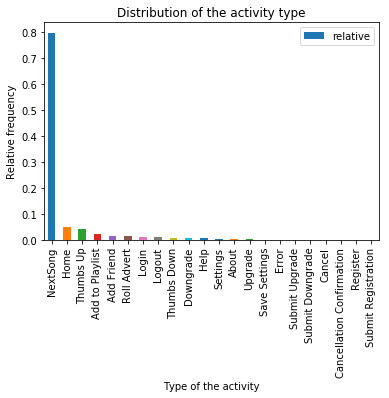

In [26]:
activities_pd.plot(x = 'page', y = 'relative', kind = 'bar');
plt.xlabel("Type of the activity");
plt.ylabel("Relative frequency");
plt.title("Distribution of the activity type");
plt.savefig('activity1');

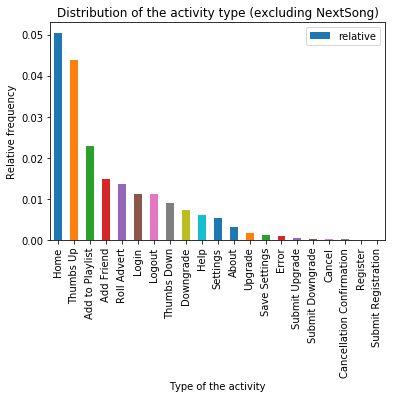

In [27]:
filtered_activities_pdf = activities_pd.drop([0])
filtered_activities_pdf.plot(x = 'page', y = 'relative', kind = 'bar');
plt.xlabel("Type of the activity");
plt.ylabel("Relative frequency");
plt.title("Distribution of the activity type (excluding NextSong)");
plt.savefig('activity2');

### Explore feature: authorization

In [28]:
df.groupby('auth').count().show()

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Cancelled|    52|
|     Guest|    97|
| Logged In|278102|
+----------+------+



In [29]:
df.filter(df.page == 'Cancellation Confirmation').distinct().count()

52

In [30]:
df.filter(df.auth == 'Cancelled').distinct().count()

52

Make sure that logs are consistent about cancellation confirmation and the cancelled status.

In [31]:
case1 = ((df.auth == 'Cancelled') & (df.page != 'Cancellation Confirmation'))
case2 = ((df.auth != 'Cancelled') & (df.page == 'Cancellation Confirmation'))
df.filter(case1 | case2).distinct().count()

0

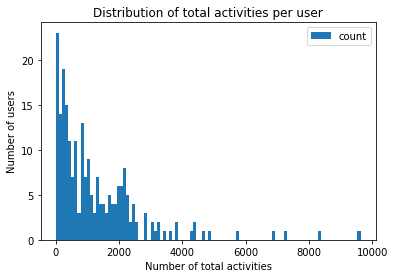

,count
count,226.000000
mean,1267.699115
std,1408.355459
min,6.000000
25%,299.500000
50%,848.000000
75%,1878.000000
max,9632.000000


In [32]:
activities_df = df.groupBy('userId').count().toPandas()
activities_df.plot(kind = 'hist', bins=100);
plt.xlabel('Number of total activities')
plt.ylabel("Number of users");
plt.title("Distribution of total activities per user");
plt.show()
activities_df.describe()

### Explore sessionId:

* how many are there in total
* how many are invalid or empty
* how does sessionId relate to userId

In [33]:
df.select('sessionId').dropDuplicates().count()

2354

In [34]:
df.where(df.sessionId.isNull()).count()

0

In [35]:
df.where(df.sessionId == "").count()

0

In [36]:
df.select('sessionId').show(5)

+---------+
|sessionId|
+---------+
|       29|
|        8|
|       29|
|        8|
|       29|
+---------+
only showing top 5 rows



Observe how many unique users have the same session id. It concludes, that session Ids are unique per user, i.e. different users can have sessions with the same Ids, which refer to each of the user and are separate sessions.

In [37]:
df.where(df.userId != "").select(['userId', 'sessionId']).dropDuplicates()\
.groupby('sessionId').count().sort('count', ascending = False).show()

+---------+-----+
|sessionId|count|
+---------+-----+
|       52|    4|
|       95|    4|
|       63|    4|
|      187|    4|
|      181|    4|
|       72|    4|
|      158|    4|
|      202|    4|
|       98|    4|
|      201|    4|
|      116|    4|
|      167|    4|
|       71|    4|
|      107|    4|
|      112|    4|
|       54|    4|
|       65|    4|
|      149|    4|
|      110|    4|
|      113|    4|
+---------+-----+
only showing top 20 rows



In [38]:
# convert to pandas for more compact visual representation
df.where(df.sessionId == '114').toPandas().head(20)

,auth,gender,level,page,ts,userId,registration,sessionId,registration_date,ts_date
0,Logged Out,None,free,Login,1540020072000,,NaN,114,NaT,2018-10-20 07:21:12
1,Logged In,M,free,Home,1540020119000,100018,1.533813e+12,114,2018-08-09 11:07:13,2018-10-20 07:21:59
2,Logged In,M,free,NextSong,1540020119000,100018,1.533813e+12,114,2018-08-09 11:07:13,2018-10-20 07:21:59
3,Logged In,M,free,Roll Advert,1540020123000,100018,1.533813e+12,114,2018-08-09 11:07:13,2018-10-20 07:22:03
4,Logged In,M,free,NextSong,1540020315000,100018,1.533813e+12,114,2018-08-09 11:07:13,2018-10-20 07:25:15
5,Logged In,M,free,NextSong,1540020447000,100018,1.533813e+12,114,2018-08-09 11:07:13,2018-10-20 07:27:27
6,Logged In,M,free,NextSong,1540020674000,100018,1.533813e+12,114,2018-08-09 11:07:13,2018-10-20 07:31:14
7,Logged In,M,free,NextSong,1540021022000,100018,1.533813e+12,114,2018-08-09 11:07:13,2018-10-20 07:37:02
8,Logged In,M,free,NextSong,1540021268000,100018,1.533813e+12,114,2018-08-09 11:07:13,2018-10-20 07:41:08
9,Logged In,M,free,NextSong,1540021489000,100018,1.533813e+12,114,2018-08-09 11:07:13,2018-10-20 07:44:49


# II Feature Engineering

The original dataset of logs consists of multiple records per user. To facilitate training a machine learning model, dataset must be reduced so that one sample (record) per user is available, with the response variable as the label for classification. To achieve that, each feature of the user has to be treated appropriately. 

* The static ones which do not change (e.g. gender) can be ascribed the same variable. 
* The dynamic ones have to be aggregated and some type of statistics should be performed on them (in case of numeric ones)

Thus, to perform statistics, time window of observation per user is necessary. By default that time window is set to the beginning and to the end of the whole observation period. For those who registered later or quit the app earlier, the time window is respectively adjusted.

After the time window being defined, various features are created based on the event types of the activity log 'page', normalized over the individual observation windows for each user:

* 'rel_thumbs_up' - amount of thumbs up given per unit time
* 'rel_thumbs_down' - amount of thumbs up given  per unit time
* 'rel_errors' - amount of error messages encountered  per unit time
* 'rel_settings' - amount of logs into settings  per unit time
num_help - amount of logs into help  per unit time
* 'rel_add_friend' - amount of friends added  per unit time
* 'rel_add_playlist' - amount of playlists added  per unit time
* 'rel_adv' - amount of advertisements rolled  per unit time
* 'rel_songs' - amount of songs played  per unit time
* 'rel_home' - amount of visits of the home screen  per unit time
num_upgrade - amount of upgrades  per unit time
num_downgrade - amount of downgrades  per unit time
* 'num_gender' - one hot encoded gender category (1 = female, 0 = male)
* 'num_level' - one hot encoded last seen subscription level category (1 = paid, 0 = free)
* 'songs_ratio' - amount of songs played over all activities
* 'rel_total_activity' - overall number of all activities


* 'label' - target binary value. 1 = churned, 0 = did not churn.


Both time points are by default specified as the start and end time point of the whole dataset. This holds for users who were using the app already before or those who did not churn. All other users fall into that default time window with their own time windows, which need to be calculated.

In [39]:
default_start_observation = 1538352000000 # midnight
default_end_observation = 1543622400000 # midnight

**Individual observation start**

Find how many users registered after the default observation start and quit before the default end.

In [40]:
df.where(df.registration > default_start_observation)\
.select('userId', 'registration_date')\
.dropDuplicates().show(10)

+------+-------------------+
|userId|  registration_date|
+------+-------------------+
|   156|2018-11-26 15:49:14|
|   153|2018-11-03 05:42:17|
|   154|2018-11-03 18:00:21|
|   155|2018-11-04 22:27:50|
|   152|2018-10-30 23:03:28|
+------+-------------------+



Explore how the registration events look like. The entries lack userId, yet this might be inferred from the sessionId (unique **per user**). To check this, logs of a certain user are explored below. It can be noted that event "Submit Registration" is preceded by an event "Register" with a second time shift, for the users. Thus only one is picked in further consideration as a reference point.

In [41]:
df.select(['userId','page','ts_date','sessionId']).where(df.page == 'Submit Registration').show()

+------+-------------------+-------------------+---------+
|userId|               page|            ts_date|sessionId|
+------+-------------------+-------------------+---------+
|      |Submit Registration|2018-10-30 06:59:07|     1402|
|      |Submit Registration|2018-11-02 15:13:19|     1506|
|      |Submit Registration|2018-11-02 15:55:56|      154|
|      |Submit Registration|2018-11-08 21:10:33|     1719|
|      |Submit Registration|2018-11-26 23:12:49|     2288|
+------+-------------------+-------------------+---------+



In [42]:
df.select(['userId','page','ts_date','sessionId']).where(df.sessionId == '1402').show()

+------+-------------------+-------------------+---------+
|userId|               page|            ts_date|sessionId|
+------+-------------------+-------------------+---------+
|      |               Help|2018-10-30 06:58:39|     1402|
|      |               Help|2018-10-30 06:58:52|     1402|
|      |           Register|2018-10-30 06:59:06|     1402|
|      |Submit Registration|2018-10-30 06:59:07|     1402|
|   152|               Home|2018-10-30 06:59:09|     1402|
|   152|           NextSong|2018-10-30 06:59:16|     1402|
|   152|           NextSong|2018-10-30 07:01:37|     1402|
|   152|           NextSong|2018-10-30 07:07:48|     1402|
|   152|           NextSong|2018-10-30 07:09:59|     1402|
|   152|           NextSong|2018-10-30 07:14:24|     1402|
|   152|           NextSong|2018-10-30 07:20:12|     1402|
|   152|           NextSong|2018-10-30 07:26:19|     1402|
|   152|           NextSong|2018-10-30 07:29:40|     1402|
+------+-------------------+-------------------+--------

One pattern can be noticed: For each unique user, the first event which contains userId is preceded by an even of registration, that does not have the userId. Thus the userId can be backpropagated from the further logs. In pyspark it can be realised with the function lag. Thus, auxiliary column is created that indicates the value of the next event for each user. Reference: 

https://medium.com/jbennetcodes/how-to-get-rid-of-loops-and-use-window-functions-in-pandas-or-spark-sql-907f274850e4

In [43]:
window_session = Window.partitionBy('sessionId').orderBy('ts')

In [44]:
df = df.withColumn('aux_shifted_value', lag(df.page).over(window_session))

Check for success:

In [45]:
df.where(df.aux_shifted_value == 'Submit Registration')\
.select(['userId', 'page', 'ts_date', 'sessionId', 'aux_shifted_value']).show()

+------+----+-------------------+---------+-------------------+
|userId|page|            ts_date|sessionId|  aux_shifted_value|
+------+----+-------------------+---------+-------------------+
|   156|Home|2018-11-26 23:14:00|     2288|Submit Registration|
|   154|Home|2018-11-02 15:15:35|     1506|Submit Registration|
|   152|Home|2018-10-30 06:59:09|     1402|Submit Registration|
|   155|Home|2018-11-02 15:56:25|      154|Submit Registration|
|   153|Home|2018-11-08 21:11:10|     1719|Submit Registration|
+------+----+-------------------+---------+-------------------+



Further, the calculations should be conducted for each user, so create partitions per user, without further sorting by time.

In [46]:
# window_user = Window.partitionBy('userId')
window_user = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

In [47]:
df = df.withColumn('first_shifted_event', first(col('aux_shifted_value')).over(window_user))
df = df.withColumn('first_seen', first(col('ts')).over(window_user))
df = df.withColumn('observation_start'\
, when(df.first_shifted_event == 'Submit Registration', df.first_seen).otherwise(default_start_observation))                

**Individual observation end**

Define the end of the observation period for each user. It is either the time of the cancellation, or the default set end time of observation. Each user obtains one timestamp that is propagated through all records of that user.

Check a few users to see their last record in the app.

In [48]:
last_records = df.groupby('userId').agg( last(col('page')).alias('lastpage'))

In [49]:
last_records.toPandas().head(30)

,userId,lastpage
0,100010,Logout
1,200002,Thumbs Up
2,125,Cancellation Confirmation
3,124,Home
4,51,Cancellation Confirmation
5,7,Thumbs Up
6,15,NextSong
7,54,Cancellation Confirmation
8,155,Home
9,100014,Cancellation Confirmation


In [50]:
df = df.withColumn('last_event', last(col('page')).over(window_user))
df = df.withColumn('last_seen', last(col('ts')).over(window_user))
df = df.withColumn('observation_end', when(df.last_event == 'Cancellation Confirmation', df.last_seen).otherwise(default_end_observation))                

Adding the start and end of the observation period for each user resulted in a few new columns (feature columns and some auxiliary ones). Check them to keep track of the new columns. Some will be deleted later on.

In [51]:
df.columns

['auth',
 'gender',
 'level',
 'page',
 'ts',
 'userId',
 'registration',
 'sessionId',
 'registration_date',
 'ts_date',
 'aux_shifted_value',
 'first_shifted_event',
 'first_seen',
 'observation_start',
 'last_event',
 'last_seen',
 'observation_end']

### Feature: last level of subscription

There can be different behavioral patterns present. Some users might be more keen to quit the app directly from their paid subscription, some who have free subscription might be more reluctant since they do not pay at that moment. Thus the feature has potential to have additional value for the machine learning model.

In [52]:
df = df.withColumn('last_sub_level', last(col('level')).over(window_user))

Since the next steps will be to derive statistics and aggregate them per user, userId has to be present and consequently the records with lacking of such should be removed.

In [53]:
df = df.where(df.userId != "")

### Aggregation:

Transition from the original dataframe of all the logs of all the users to a dataframe where each row corresponds to one user, being one sample of the dataset.


Drop:
* sessionId, 
* auth - used to calculate other features. Dynamic per user.
* aux_shifted - auxiliary column
* first shifted, first seen, last seen - temporary columns
* page - dynamic per user, used to calculate other features
* ts, tsdate, registration, registration_date - necessary to calculate the individual observation time windows

Keep:
* userId - keep until feature engineering
* observation_start - keep until feature engineering
* observation_end - keep until feature engineering
* gender - static per user, should be one hot encoded (1 = female, 0 = male)
* last_sub_level - dynamic per user, should be one hot encoded (at the end of the observation period: 1 = paid, 0 = free)
* last_event - required to calculate variable response

Create:
* num_thumbs_up - amount of thumbs up given
* num_thumbs_down - amount of thumbs up given
* num_errors - amount of error messages encountered
* num_settings - amount of logs into settings
* num_help - amount of logs into help
* num_add_friend - amount of friends added
* num_add_playlist - amount of playlists added
* num_adv - amount of advertisements rolled
* num_songs - amount of songs played
* num_home - amount of visits of the home screen
* num_upgrade - amount of upgrades
* num_downgrade - amount of downgrades


In [54]:
df_user = df.groupby('userId')\
.agg( # some function, for some column, with an .alias for its final name
    
    # keep and one hot encode gender (1=female, 0=male)
    first(when(col('gender') == 'F', 1).otherwise(0)).alias('num_gender'),

    # keep and one hot encode last subscription level (1=paid 0=free)
    first(when(col('last_sub_level') == 'paid', 1).otherwise(0)).alias('num_level'),
    
    # aggregate activities per user per category
    spark_sum(when(col('page') == "Thumbs Up", 1).otherwise(0)).alias("num_thumbs_up"),
    spark_sum(when(col('page') == "Thumbs Down", 1).otherwise(0)).alias("num_thumbs_down"),
    spark_sum(when(col('page') == "Error", 1).otherwise(0)).alias("num_errors"),
    spark_sum(when(col('page') == "Settings", 1).otherwise(0)).alias("num_settings"),
    spark_sum(when(col('page') == "Help", 1).otherwise(0)).alias("num_help"),
    spark_sum(when(col('page') == "Add to Playlist", 1).otherwise(0)).alias("num_add_playlist"), 
    spark_sum(when(col('page') == "Add Friend", 1).otherwise(0)).alias("num_add_friend"),
    spark_sum(when(col('page') == "Roll Advert", 1).otherwise(0)).alias("num_adv"),
    spark_sum(when(col('page') == "NextSong", 1).otherwise(0)).alias("num_songs"),
    spark_sum(when(col('page') == "Home", 1).otherwise(0)).alias("num_home"),
    spark_sum(when(col('page') == "Submit Upgrade", 1).otherwise(0)).alias("num_upgrade"),
    spark_sum(when(col('page') == "Submit Downgrade", 1).otherwise(0)).alias("num_downgrade"),
    count(col('page')).alias('total_activity'),
    # keep observation related columns
    first(col('observation_start')).alias('observation_start'),
    first(col('observation_end')).alias('observation_end'),
    # keep last_event to derive target for learning later on
    first(col('last_event')).alias('last_event'),
)

### Feature engineering continued

The aggregated statistics are based on the observation time frame and as such do not add to the predictive power. Especially in case of new users, such calculated features would be misleading. It is necessary to normalize them over time and eventually change absolute values into ratio values.

In [55]:
df_user = df_user.withColumn('total_hours', (col('observation_end') - col('observation_start')) / 1000 / 3600)\
.withColumn('rel_thumbs_up', col('num_thumbs_up') / col('total_hours'))\
.withColumn('rel_thumbs_down', col('num_thumbs_down') / col('total_hours'))\
.withColumn('rel_errors', col('num_errors') / col('total_hours'))\
.withColumn('rel_settings', col('num_settings') / col('total_hours'))\
.withColumn('rel_help', col('num_help') / col('total_hours'))\
.withColumn('rel_add_playlist', col('num_add_playlist') / col('total_hours'))\
.withColumn('rel_add_friend', col('num_add_friend') / col('total_hours'))\
.withColumn('rel_adv', col('num_adv') / col('total_hours'))\
.withColumn('rel_songs', col('num_songs') / col('total_hours'))\
.withColumn('rel_home', col('num_home') / col('total_hours'))\
.withColumn('rel_total_activity', col('total_activity') / col('total_hours'))\
.withColumn('songs_ratio', col('num_songs') / col('total_activity'))

### Define target variable.
Binary value, so that the binary classifier can be trained to predict churning.

Possible values:

* **1** : churned
* **0** : did not churn

In [56]:
df_user = df_user.withColumn('label', when(df_user.last_event == "Cancellation Confirmation", 1).otherwise(0))

Compare how many users cancelled the subscription (value 1) and how many did not (value 0)

In [57]:
df_user.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



In [58]:
df_user.toPandas().head(20)

,userId,num_gender,num_level,num_thumbs_up,num_thumbs_down,num_errors,num_settings,num_help,num_add_playlist,num_add_friend,...,rel_settings,rel_help,rel_add_playlist,rel_add_friend,rel_adv,rel_songs,rel_home,rel_total_activity,songs_ratio,label
0,100010,1,0,17,5,0,0,2,7,4,...,0.000000,0.001366,0.004781,0.002732,0.035519,0.187842,0.007514,0.260246,0.721785,0
1,200002,0,1,21,6,0,3,2,8,4,...,0.002049,0.001366,0.005464,0.002732,0.004781,0.264344,0.013661,0.323770,0.816456,0
2,125,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.003723,0.029785,0.000000,0.040955,0.727273,1
3,124,1,1,171,41,6,20,23,118,74,...,0.013661,0.015710,0.080601,0.050546,0.002732,2.786202,0.120219,3.295765,0.845389,0
4,51,0,1,100,21,1,12,12,52,28,...,0.030639,0.030639,0.132769,0.071491,0.000000,5.389894,0.191493,6.291189,0.856737,1
5,7,0,0,7,1,1,3,1,5,1,...,0.002049,0.000683,0.003415,0.000683,0.010929,0.102459,0.006831,0.137295,0.746269,0
6,15,0,1,81,14,2,16,8,59,31,...,0.010929,0.005464,0.040301,0.021175,0.000683,1.307377,0.063525,1.556011,0.840211,0
7,54,1,1,163,29,1,17,17,72,33,...,0.016542,0.016542,0.070061,0.032112,0.045735,2.764509,0.125527,3.344462,0.826593,1
8,155,1,1,58,3,3,5,9,24,11,...,0.007352,0.013234,0.035291,0.016175,0.011764,1.205776,0.044114,1.473400,0.818363,0
9,100014,0,1,17,3,0,1,2,7,6,...,0.000820,0.001641,0.005742,0.004922,0.001641,0.210817,0.005742,0.254292,0.829032,1


### Correlation of the features

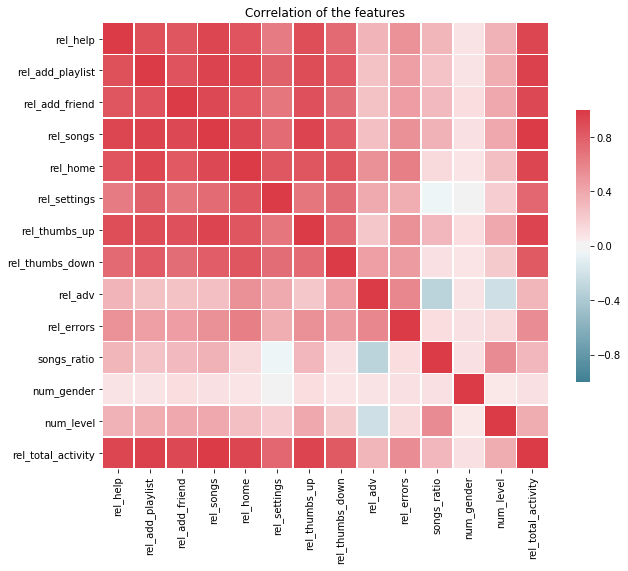

In [59]:
# for visualization purposes, work with pandas dataframe

pick_columns = [
 'rel_help',
    'rel_add_playlist',
    'rel_add_friend',
    'rel_songs',
    'rel_home',
    'rel_settings',
    'rel_thumbs_up',
    'rel_thumbs_down',
    'rel_adv',
    'rel_errors',
    'songs_ratio',
    'num_gender',
    'num_level',
'rel_total_activity']

correlation_matrix = df_user.toPandas()[pick_columns].corr()
plt.subplots(figsize=(10, 10))
sns.heatmap(correlation_matrix, cmap = sns.diverging_palette(220, 10, as_cmap = True), square = True, vmin = -1, vmax = 1, linewidths=.7, cbar_kws={"shrink": .5})
plt.title('Correlation of the features');

# III Modeling

This section aims at preparing the dataset for a machine learning model, instantiating, performing training, evaluation and optionally hyperparameter tuning for the best model.

In particular, the following steps are required:
* merge columns into spark column vector (done with VectorAssembler)
* scale numerical features
* add categorical features to the spark column vector
* perform train-test split
* instantiate each ml model and form pipelines together with data preprocessing steps
* fit on the data coming out of the pipeline
* evaluate and compare models
* refine most promising model


### Step 1: Form preprocessing pipeline with data split

In [60]:
%%time
numerical_columns = [
    'rel_thumbs_up',
    'rel_thumbs_down',
    'rel_errors',
    'rel_settings',
    'rel_help',
    'rel_add_playlist',
    'rel_add_friend',
    'rel_adv',
    'rel_songs',
    'rel_home',
    'rel_total_activity',
    'songs_ratio']


# 1. instantiate VectorAssembler to merge columns into spark column vector (done with VectorAssembler)
numerical_assembler = VectorAssembler(inputCols = numerical_columns,
                           outputCol='feats_numerical_vectorized')

# 2. instantiate StandardScaler to scale numerical features
scaler = StandardScaler(inputCol = "feats_numerical_vectorized", outputCol = "feats_numerical_vectorized_scaled", withStd = True, withMean = True)

# 3. add categorical features to the spark column vector
categorical_columns = ['num_gender', 'num_level']
all_feature_columns = ['feats_numerical_vectorized_scaled'] + categorical_columns
final_assembler = VectorAssembler(inputCols = all_feature_columns, outputCol = 'features')

# 4. split data
train_val_data, test_data = df_user.randomSplit([0.7, 0.3], seed = 43) 
num_all_data = df_user.count()
num_train_val = train_val_data.count()
num_test = test_data.count()

print(f"Whole dataset size: {num_all_data} samples. Split into {num_train_val} samples for train and val, {num_test} samples for test.")

Whole dataset size: 225 samples. Split into 161 samples for train and val, 64 samples for test.
CPU times: user 13 ms, sys: 0 ns, total: 13 ms
Wall time: 31.4 s


### Step 2: Instantiate model(s), perform crossvalidation and report on best model parameters

In [61]:
%%time

# instantiate default ml models and parameter grid for cv
lr = LogisticRegression(labelCol = 'label', featuresCol = 'features')
paramgrid_lr = ParamGridBuilder()\
.addGrid(lr.maxIter, [10, 25]) \
.addGrid(lr.regParam, [0.0, 0.2]) \
.build()

rf = RandomForestClassifier(labelCol = 'label', featuresCol = 'features', seed = 43)
paramgrid_rf = ParamGridBuilder() \
.addGrid(rf.maxDepth, [2, 5, 10]) \
.addGrid(rf.numTrees, [10, 30, 40]) \
.build()



def train_crossvalidate(train_val_data, model, cv_paramgrid):
    """Prepares pipeline, crossvalidates model
    
    """
    # finalize pipeline
    stages = [numerical_assembler, scaler, final_assembler, model]
    pipeline = Pipeline(stages = stages)


    # grid search with cross validation
    crossvalidator = CrossValidator(estimator = pipeline,
                              estimatorParamMaps = cv_paramgrid,
#                               evaluator = BinaryClassificationEvaluator(),
                                evaluator = MulticlassClassificationEvaluator(),
                              numFolds = 3)
    
    cv_model = crossvalidator.fit(train_val_data)

    # read the results of crossvalidation
    scores = cv_model.avgMetrics
    params = [{p.name: v for p, v in m.items()} for m in cv_model.getEstimatorParamMaps()]
    params_pd = pd.DataFrame(params)
    params_pd['AUC score'] = scores
    print(params_pd)
    return params_pd
    
# perform actual crossvalidation for each model and read results
params_performance_table = {}
results_lr = train_crossvalidate(train_val_data, model = lr, cv_paramgrid = paramgrid_lr)
params_performance_table['logreg'] = results_lr
results_rf = train_crossvalidate(train_val_data, model = rf, cv_paramgrid = paramgrid_rf)
params_performance_table['rf'] = results_rf

   maxIter  regParam  AUC score
0       10       0.0   0.796025
1       10       0.2   0.717579
2       25       0.0   0.774227
3       25       0.2   0.717579
   maxDepth  numTrees  AUC score
0         2        10   0.709993
1         2        30   0.728410
2         2        40   0.706769
3         5        10   0.763964
4         5        30   0.790762
5         5        40   0.779321
6        10        10   0.768263
7        10        30   0.784571
8        10        40   0.786336
CPU times: user 5.87 s, sys: 1.52 s, total: 7.39 s
Wall time: 25min 44s


In [62]:
params_performance_table['logreg']

,maxIter,regParam,AUC score
0,10,0.0,0.796025
1,10,0.2,0.717579
2,25,0.0,0.774227
3,25,0.2,0.717579


In [63]:
params_performance_table['rf']

,maxDepth,numTrees,AUC score
0,2,10,0.709993
1,2,30,0.728410
2,2,40,0.706769
3,5,10,0.763964
4,5,30,0.790762
5,5,40,0.779321
6,10,10,0.768263
7,10,30,0.784571
8,10,40,0.786336


### Step 3: Retrain most promising model with best paramset found, evaluate final performance.

In [71]:
%%time
all_results = {}
best_lr =  LogisticRegression(maxIter = 10, regParam = 0.0)
best_rf = RandomForestClassifier(labelCol = 'label', featuresCol = 'features', maxDepth=5, numTrees=30, seed = 43)


def retrain_best_eval(train_val_data, test_data, best_model, name=None):
    """Retrains again with the best paramset found in cv, evaluates
    
    """
    assert name, "Define the name of the model"
    
    pipeline_best_model = Pipeline(stages = [numerical_assembler, scaler, final_assembler, best_model])
    best_trained_model = pipeline_best_model.fit(train_val_data)

    def perform_final_evaluation(best_trained_model, test_data, name=None):
        """Evaluates model

        """
        # predict on test data
        output_preds = best_trained_model.transform(test_data)
        output_preds.select(['userId','label','rawPrediction','probability','prediction']).show(5)

        # evaluate: f1 metric
        evaluator = MulticlassClassificationEvaluator() #BinaryClassificationEvaluator()
#         results_auc = evaluator_auc.evaluate(output_preds)
#         print(f'{name} AUC score: {results_auc}')
        results_f1 = evaluator.evaluate(output_preds, {evaluator.metricName:'f1'})
        print(f'{name} F1 score: {results_f1}')

        return results_f1 #results_auc, 

    results_f1 = perform_final_evaluation(best_trained_model, test_data, name)
    
    return results_f1, best_trained_model

    
# call on logreg
name = "logistic_regression"
lr_f1, best_lr_model = retrain_best_eval(train_val_data, test_data, best_lr, name=name)
all_results[name] = {}
# all_results[name]['results_auc'] = lr_auc
all_results[name]['results_f1'] = lr_f1
all_results[name]['best_trained_model'] = best_lr_model

name = "random_forest"
rf_f1, best_rf_model = retrain_best_eval(train_val_data, test_data, best_rf, name=name)
all_results[name] = {}
# all_results[name]['results_auc'] = rf_auc
all_results[name]['results_f1'] = rf_f1
all_results[name]['best_trained_model'] = best_rf_model

+------+-----+--------------------+--------------------+----------+
|userId|label|       rawPrediction|         probability|prediction|
+------+-----+--------------------+--------------------+----------+
|   124|    0|[1.71607220721987...|[0.84762221975087...|       0.0|
|    54|    1|[0.56216412386835...|[0.63695312876706...|       0.0|
|   155|    0|[2.67097853128838...|[0.93529227795712...|       0.0|
|   138|    0|[0.47335580620976...|[0.61617772254233...|       0.0|
|100021|    1|[1.34553613211558...|[0.79339888220580...|       0.0|
+------+-----+--------------------+--------------------+----------+
only showing top 5 rows

logistic_regression F1 score: 0.7710858585858585
+------+-----+--------------------+--------------------+----------+
|userId|label|       rawPrediction|         probability|prediction|
+------+-----+--------------------+--------------------+----------+
|   124|    0|[17.0025365293760...|[0.56675121764586...|       0.0|
|    54|    1|[16.4200903774588...|[0.5473

In [75]:
all_results['logistic_regression']['results_f1']

0.7710858585858585

In [76]:
all_results['random_forest']['results_f1']

0.7924107142857143

In many business cases, such as potentially this one, interpretability of features is crucial. This is where the strengths of the chosen approach shows, since a random forest algorithm is relatively easily interpretable. Below their summary:

In [77]:
feats_with_importance = all_results[name]['best_trained_model'].stages[-1].featureImportances
feats_with_importance_list = [feats_with_importance[i] for i in range(len(feats_with_importance))]
feats_with_importance_list
feature_names = categorical_columns + numerical_columns
pd.DataFrame({"feature": feature_names,"importance": feats_with_importance_list, }).sort_values('importance', ascending = False)

,feature,importance
7,rel_add_playlist,0.196411
3,rel_thumbs_down,0.146880
11,rel_home,0.128230
6,rel_help,0.082749
0,num_gender,0.068526
5,rel_settings,0.068074
1,num_level,0.067234
9,rel_adv,0.059270
8,rel_add_friend,0.054104
10,rel_songs,0.048130


Short analysis of feature importance showed that the strongest features were the relative number of thumbs up given by the user and the number of created playlists. The former feature means obviously that the user was happy each time giving thumbs up, so gathered positive experience with the service. Importance of added playlists can be understood as a convenience that accumulates over time, of having an own digital music library, that makes the user eager to not try out other services while this one works well. On the other hand, a number of added friends turned out not to be so crucial, apparently friendships are based not only on music or are not so strong.

The least important features turned out to be the relative total activity over time period and ratio of played songs compared to all activities. It might be a bit counterintuitive, one possibility is to introduce a more fine grained time window, such as trend. As for song ratio, the same idea could give better insight. They are described in the outlook section.

I can conclude from my analysis that a random forest model would show robust performance if at least the top 2 significant features were available and clean in the data (explained variance almost 50% together). On the other hand, even if some data from the less important features would be distorted or missing, this should not have a huge negative impact on the robustness of the model.


As seen, cross-validation process helped to find optimal values for the considered parameters of the models, instead of just taking the default ones. Due to class imbalance, F1 score was considered as a metric to compare performance. Both logistic regression and random forest scored very similarly. 

For many business use-cases, interpretability in the long run can be more beneficial than current good performance, because it helps to scale (more data, more potential features) together with the business use-case. This is exactly what random forest offers and together with the obtained results I am satisfied with the outcome.


## Reflection

Based on the obtained results and F1 score results, I think that quite well performing model has been developed. The model does not only consider accuracy, but precision and recall as well and as such, once deployed, it would be supportive to identify users who are about to quit the streaming service.
The most challenging part was feature engineering. Firstly, it required some bit of intuition and creativity specifically tailored to this problem set. Secondly, the model is aimed at being deployed and so the features had to be engineered in a way that in on-line on the fly predictions, the model would be able to transform incoming data into them.


## Outlook & Improvements

As always, there is space for further improvements. To name a few examples:
1. Spend more time on feature engineering and come up with more features. In particular aspects such as trends could be addressed. If the user behavior changed over the last 2 weeks, deviating from the user’s average, that could be an indicator of a possible quitting. Furthermore, in this way features like song ratio or relative total activity could gain more on importance and their interpretability would improve.

2. Fully automatise machine learning pipeline, including hyperparameter tuning, model testing and refinement.

3. Optimize further spark code, possibly grasping for low level API and work directly with RDDs.

4. Perform more comprehensive grid search, or even add a random parameter search stage before grid search

5. Identify shifts in data distribution over time, in on-line scenarios. This would mean that statistics of the newer data (or bigger dataset, like in the example of the full dataset) would deviate from the development set. Compensate for that with sampling methods.
